In [1]:
import intake
import numpy as np
from climtas.nci import GadiClient
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
import metpy

In [3]:
client = GadiClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41581,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:37451,Total threads: 1
Dashboard: /proxy/34231/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:33757,


In [4]:
#See here: https://opus.nci.org.au/pages/viewpage.action?pageId=264241965
data_catalog = intake.open_esm_datastore("/g/data/ob53/catalog/v2/esm/catalog.json")

In [5]:
#ds = data_catalog.search(variable_id="uas",domain_id="AUS-11",freq="1hr",start_time=[202312,202401,202402]).to_dask(xarray_open_kwargs={'chunks':{'time':-1}})

def combine_winds(u,v,uname,vname,ws_name):

    wind_da = xr.Dataset({uname:u[uname],vname:v[vname]})
    wind_da[ws_name] = np.sqrt(wind_da[uname]**2 + wind_da[vname]**2)

    return wind_da

lat_slice = slice(-44,-29)
lon_slice = slice(140,156)

unames = ["uas","ua50m","ua100m","ua150m","ua200m","ua250m","ua1500m"]
vnames = ["vas","va50m","va100m","va150m","va200m","va250m","va1500m"]
ws_names = ["ws_sfc","ws_50m","ws_100m","ws_150m","ws_200m","ws_250m","ws_1500m"]

# unames = ["uas","ua1000","ua925","ua850","ua700"]
# vnames = ["vas","va1000","va925","va850","va700"]
# ws_names = ["ws_sfc","ws_1000","ws_925","ws_850","ws_va700"]

times = [202312,202401,202402]

wind_ds_list = []
for uname,vname,wsname in zip(unames,vnames,ws_names):
    u_ds = data_catalog.search(variable_id=uname,
                        domain_id="AUS-11",
                        freq="1hr",
                        start_time=times).to_dask().sel(lon=lon_slice, lat=lat_slice)
    v_ds = data_catalog.search(variable_id=vname,
                        domain_id="AUS-11",
                        freq="1hr",
                        start_time=times).to_dask().sel(lon=lon_slice, lat=lat_slice)
    wind_ds_list.append(combine_winds(u_ds,v_ds,uname,vname,wsname)\
                       .chunk({"time":-1,"lat":20,"lon":20}))

orog = data_catalog.search(variable_id="orog",domain_id="AUS-11").to_dask().sel(lon=lon_slice, lat=lat_slice)

In [68]:
wind_ds = xr.merge(wind_ds_list,compat="override")

In [101]:
wind_mean = wind_ds.mean("time").persist()
wind_grouped = wind_ds.groupby("time.hour").mean().persist()
wind_hourly_anom = (wind_grouped - wind_mean)

In [70]:
def plot_wind(wind_ds,uname,vname,wsname,ax,vmax=None,vmin=None,cmap=None,ws=True):
    if ws:
        wind_ds[wsname].plot(vmax=vmax,vmin=vmin,cmap=cmap)
    wind_ds[[uname,vname]].coarsen({"lon":5,"lat":5},boundary="pad").mean().plot.quiver(x="lon",y="lat",u=uname,v=vname,scale=50)
    ax.coastlines()
    ax.gridlines(draw_labels=True)

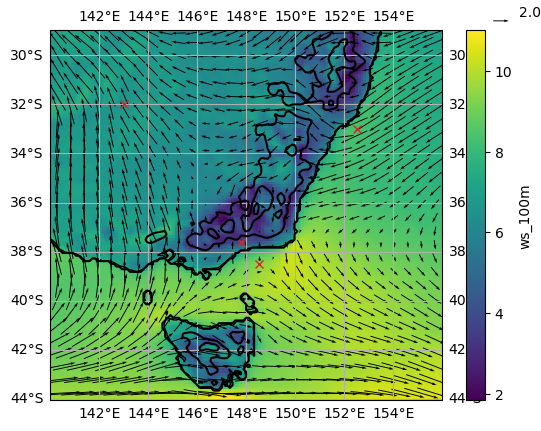

In [97]:
plot_wind(wind_mean,"ua100m","va100m","ws_100m",plt.axes(projection=ccrs.PlateCarree()))

lats = [-38.5,-37.6,-32,-33]
lons = [148.5,147.8,143,152.5]
plt.gca().plot(lons,lats,ls="none",marker="x",color="tab:red")

xr.plot.contour(orog.orog,levels=[0,500,1000,1500],colors="k")

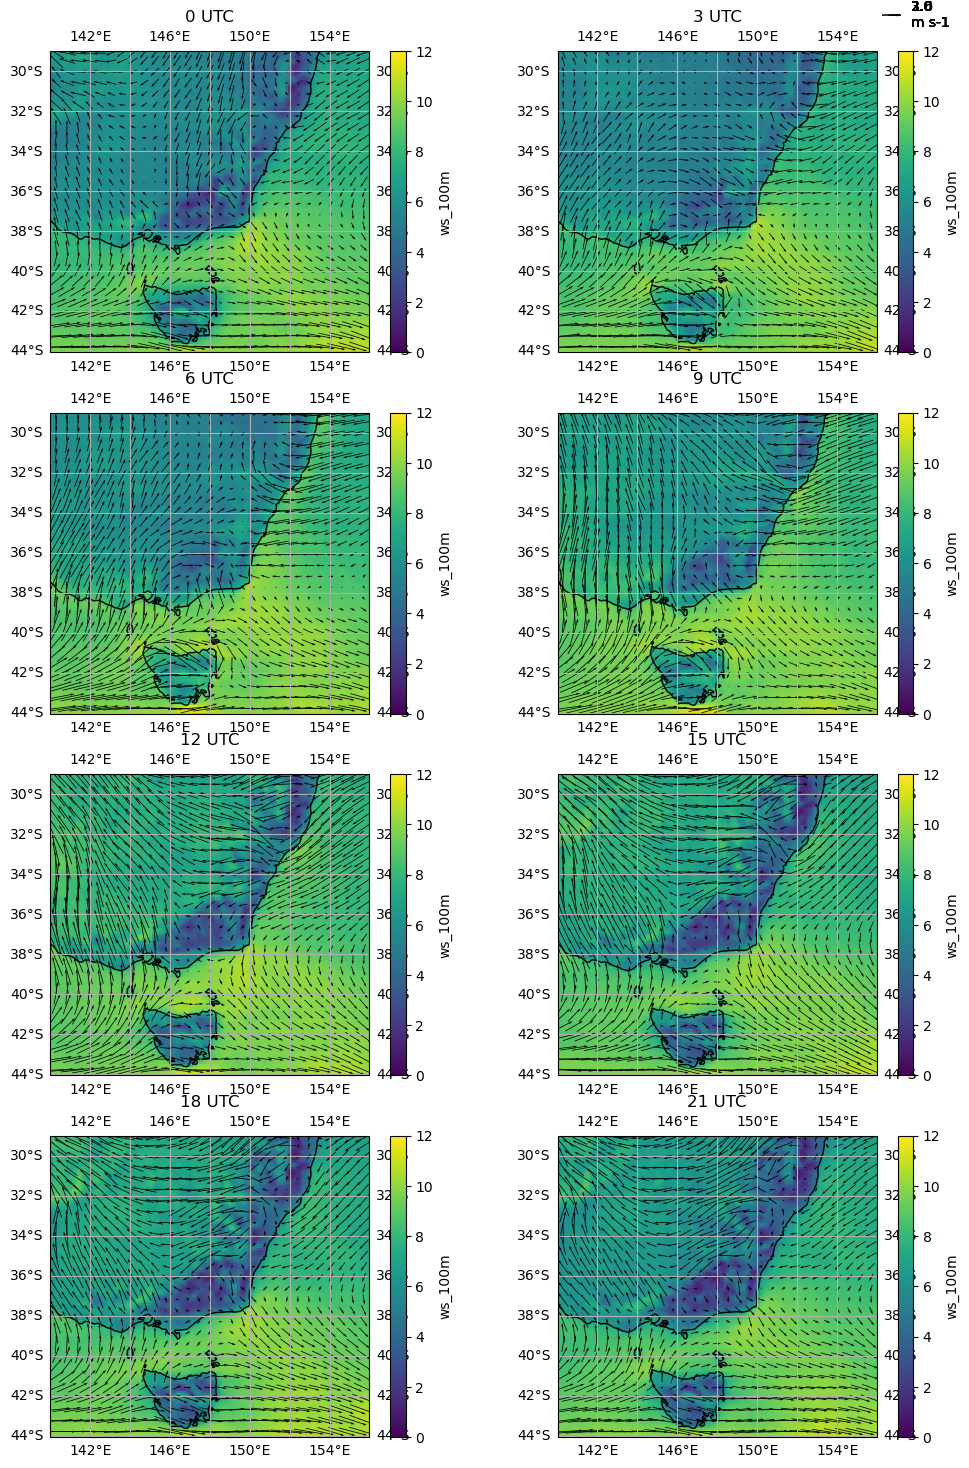

In [108]:
cnt=1
plt.figure(figsize=[12,18])
for hour in [0,3,6,9,12,15,18,21]:
    ax=plt.subplot(4,2,cnt,projection=ccrs.PlateCarree())
    plot_wind(wind_grouped.sel(hour=hour),"ua100m","va100m","ws_100m",ax=ax,vmin=0,vmax=12, cmap=None)
    plt.title(str(hour) +" UTC")
    cnt=cnt+1

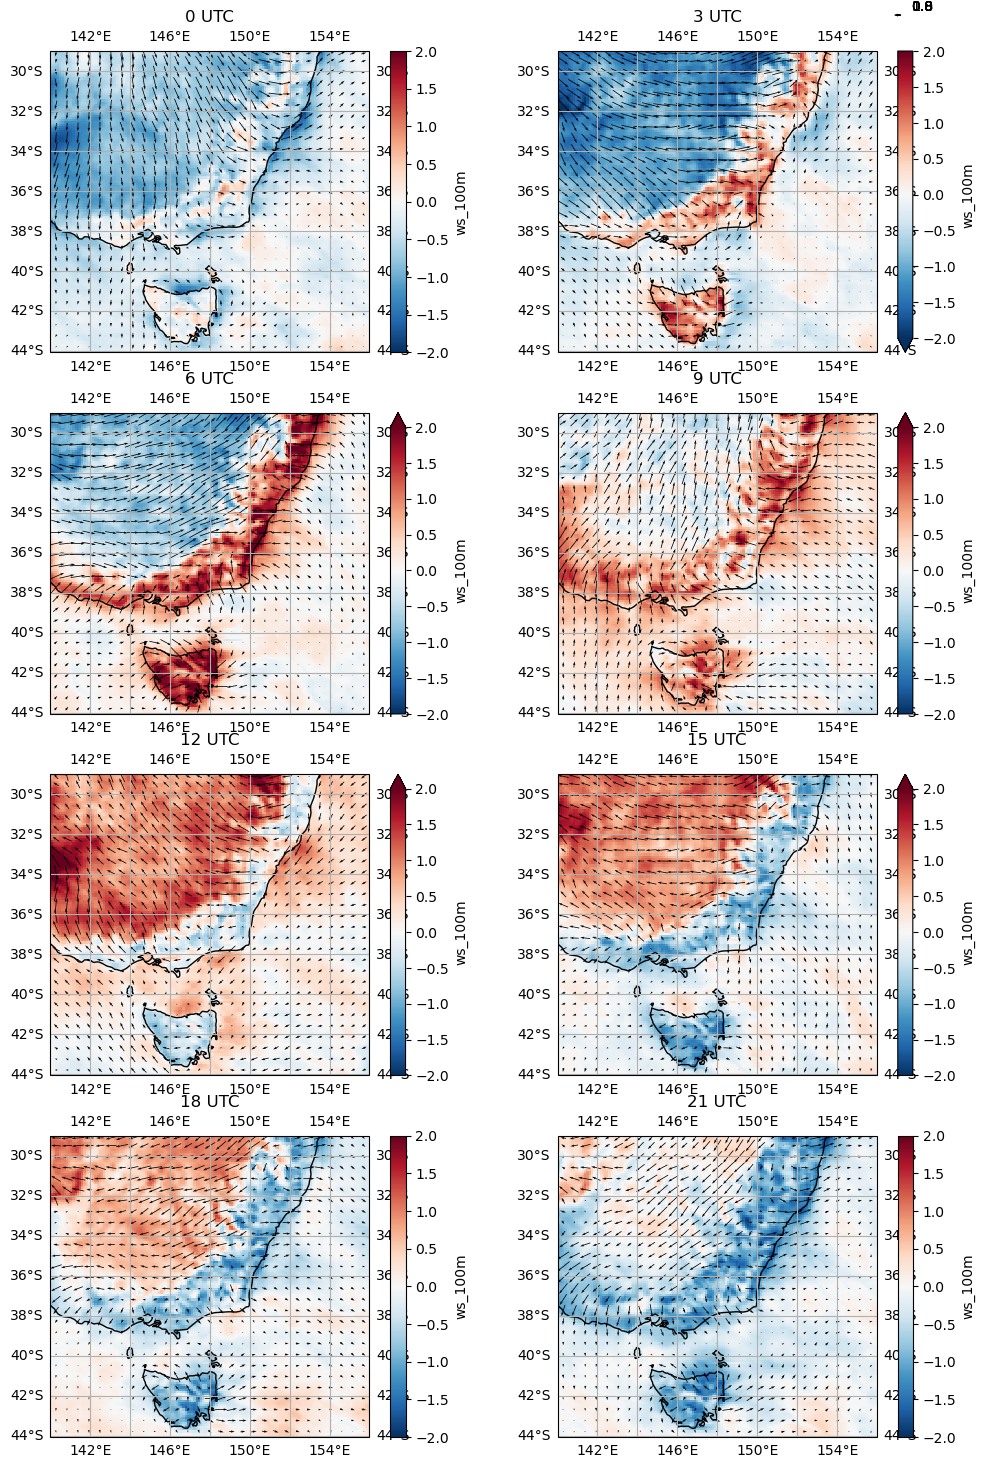

In [72]:
cnt=1
plt.figure(figsize=[12,18])
for hour in [0,3,6,9,12,15,18,21]:
    ax=plt.subplot(4,2,cnt,projection=ccrs.PlateCarree())
    plot_wind(wind_hourly_anom.sel(hour=hour),"ua100m","va100m","ws_100m",ax=ax,vmin=-2,vmax=2, cmap="RdBu_r")
    plt.title(str(hour) +" UTC")
    cnt=cnt+1

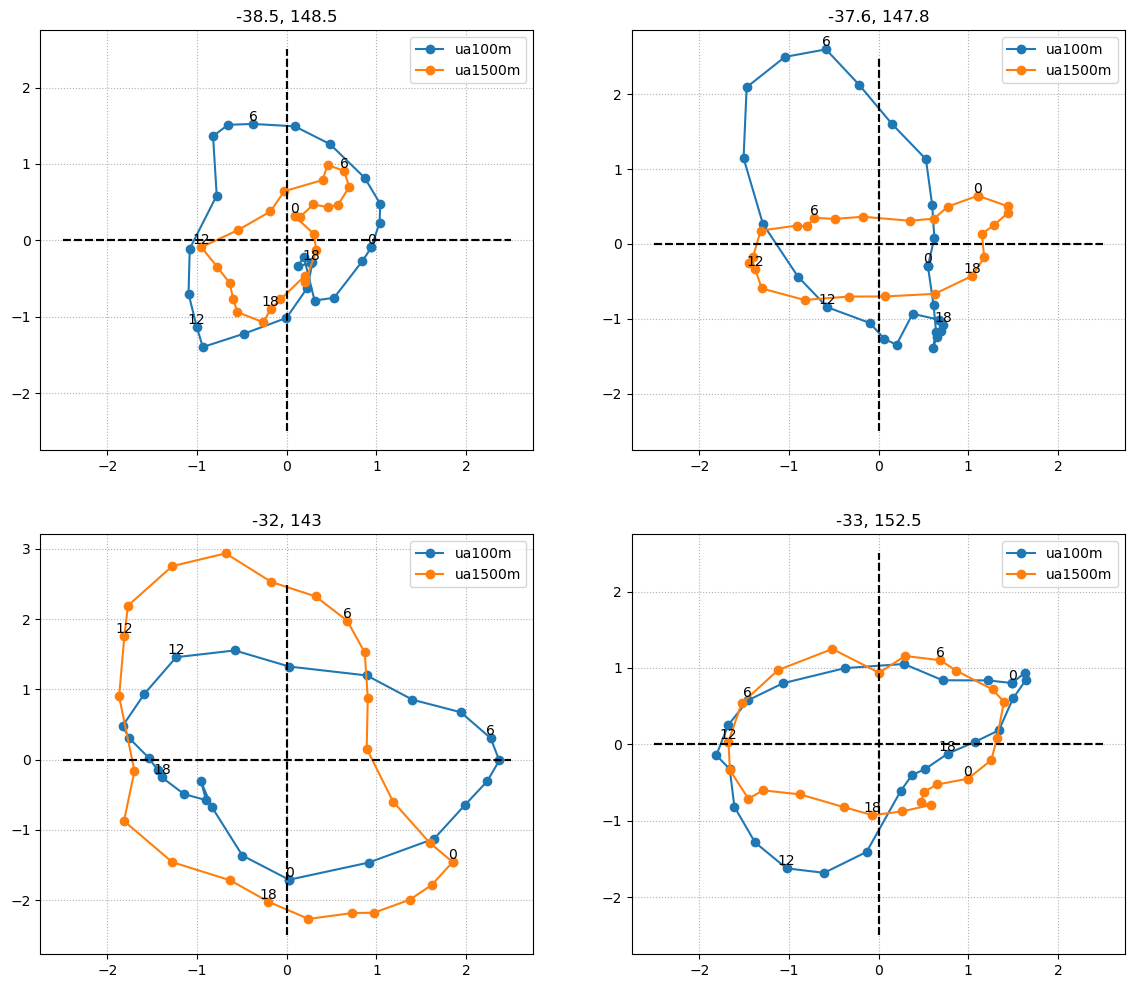

In [98]:
unames = ["ua100m","ua1500m"]
vnames = ["va100m","va1500m"]

plt.figure(figsize=[14,12])
for i in range(len(lats)):
    plt.subplot(2,2,i+1)
    lat = lats[i]
    lon = lons[i]
    for uname,vname in zip(unames,vnames):
        wind_hourly_anom_point = wind_hourly_anom.sel(lat=lat,lon=lon,method="nearest")
        
        u_comp = wind_hourly_anom_point[uname].values
        v_comp = wind_hourly_anom_point[vname].values
        u_comp = np.append(u_comp,u_comp[0])
        v_comp = np.append(v_comp,v_comp[0])
        
        plt.plot(u_comp,v_comp,marker="o",label=uname)
        [plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]
        plt.gca().grid(ls=":")
        plt.plot([0,0],[-2.5,2.5],color="k",ls="--")
        plt.plot([-2.5,2.5],[0,0],color="k",ls="--")
    plt.legend()
    plt.title(str(lat)+", "+str(lon))

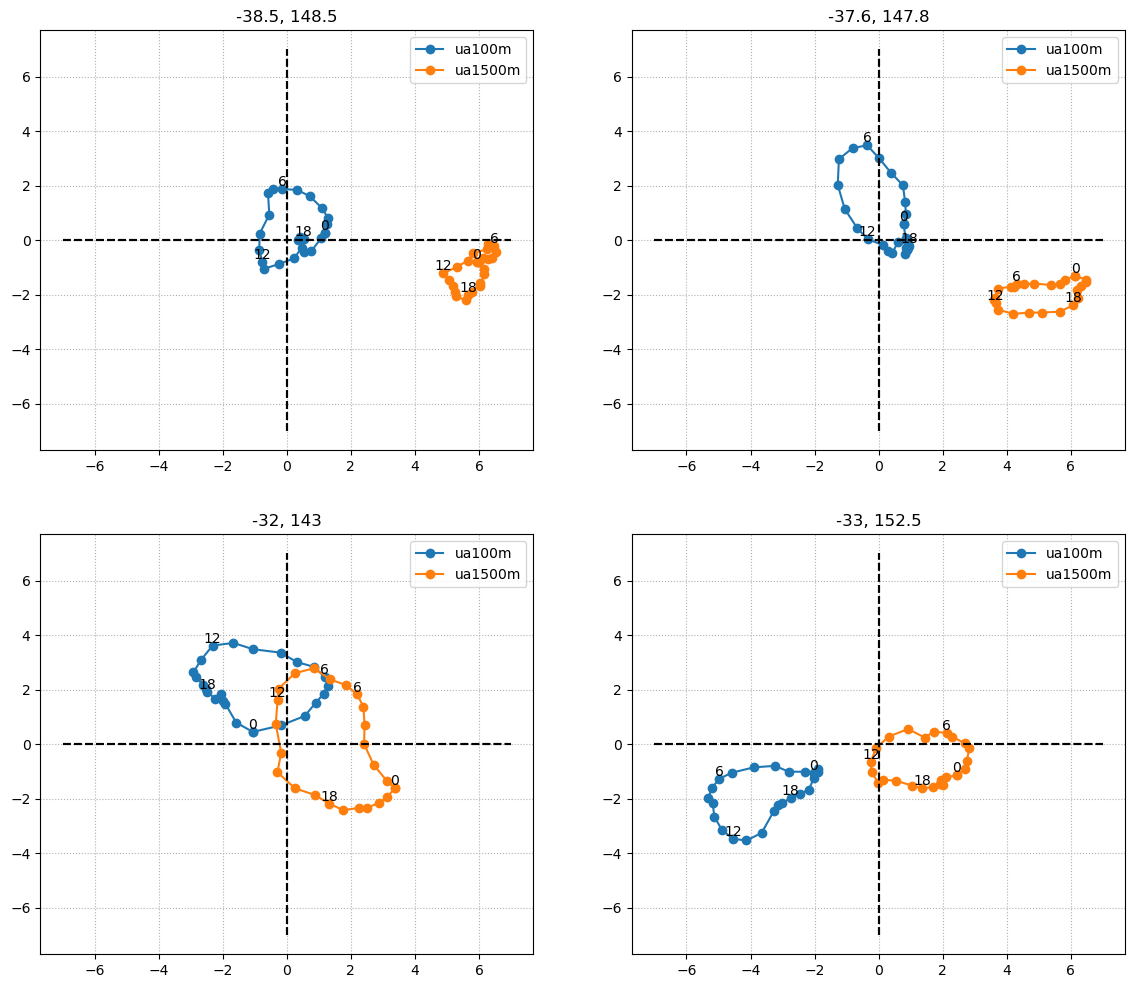

In [103]:
unames = ["ua100m","ua1500m"]
vnames = ["va100m","va1500m"]

plt.figure(figsize=[14,12])
for i in range(len(lats)):
    plt.subplot(2,2,i+1)
    lat = lats[i]
    lon = lons[i]
    for uname,vname in zip(unames,vnames):
        wind_grouped_point = wind_grouped.sel(lat=lat,lon=lon,method="nearest")
        
        u_comp = wind_grouped_point[uname].values
        v_comp = wind_grouped_point[vname].values
        u_comp = np.append(u_comp,u_comp[0])
        v_comp = np.append(v_comp,v_comp[0])
        
        plt.plot(u_comp,v_comp,marker="o",label=uname)
        [plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]
        plt.gca().grid(ls=":")
        plt.plot([0,0],[-7,7],color="k",ls="--")
        plt.plot([-7,7],[0,0],color="k",ls="--")
    plt.legend()
    plt.title(str(lat)+", "+str(lon))